In [3]:
import collections
import numpy as np
import pandas as pd
import platform
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import rc
from gensim.models import Word2Vec


In [4]:
data = pd.read_excel("data.xlsx")
data.head(5)

,emotion,therapy,content
0,행복,from,<행복 향유하기>
1,행복,자축하기,우수한 업무성과나 탁월한 발표 등 긍정적인 사건에 대해 다른 사람들이 얼마나 깊은 ...
2,행복,행동으로 표현하기,기쁠 때 크게 웃거나 노래를 부르는 등의 적극적인 신체적인 행동 표출은 긍정적인 감...
3,행복,세밀하게 감각을 음미하기,즐거운 경험에 주의를 기울이며 그 세부적인 내용과 요소들을 음미하는 것입니다. 와인...
4,행복,일시성 인식하기,이 순간은 다시 돌아오지 않습니다. 매 순간을 소중하게 생각하고 현재의 긍정적 경험...


In [79]:
dir = "data.xlsx"

class check_data():
    def __init__(self,df):
        self.df = self.merge(df)
        self.wiki_model = Word2Vec.load('./ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'

        self.df['therapy_Morps'] = self.df['therapy'].map(lambda x: self.getMorps(x))
        self.df['therapy_NV'] = self.df['therapy_Morps'].map(lambda x: self.getNV(x))
        self.df['therapy_N'] = self.df['therapy_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df['therapy_count_topn_NV']  = self.df['therapy_NV'].map(lambda x: self.counter(x,n)) 
        self.df['therapy_count_topn_N']  = self.df['therapy_N'].map(lambda x: self.counter(x,n)) 

    
    def merge(self,df):
        em_name = ['행복', '열정', '두려움', '분노', '우울', '슬픔']
        e = "행복"
        em_idx = []
        for idx in df.index:
            if e != df['emotion'][idx]:
                em_idx.append(idx)
                e = df['emotion'][idx]

        em_idx.insert(0,0)
        em_idx.append(df.index.max())
        
        em_list = []
        for idx in range(0,len(em_idx)-1):
            sub_list = []
            sub_list.append(em_name[idx])
            sub_list.append(df['content'][em_idx[idx]+1:em_idx[idx+1]].sum())
            #print(em_idx[idx])
            em_list.append(sub_list)

        return pd.DataFrame(em_list,columns=['emotion','therapy'])

    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, emotion_name,figsize):
        plt.rc('font', family=self.font)
        result = []
        x =   self.df[self.df['emotion'] == emotion_name].index.tolist()[0]
        indf = self.df['therapy_count_topn_N'][x]
        
        for out_word in indf:
            sub_result = []
            for in_word in indf:
                try:
                    sub_result.append(self.wiki_model.wv.similarity(out_word, in_word))
                except:
                    sub_result.append(0)
            result.append(sub_result)
        
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'{emotion_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(indf)),indf)
        plt.yticks(np.arange(len(indf)),indf)
        plt.show()
        
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def count_to_csv(self,file_name):
        em_name = ['행복' , '열정' , '두려움', '분노' , '우울' , '슬픔']
        em_idx = []
        for em in em_name:
            em_idx.append(em)
            em_idx.append(em + "count")
            em_idx.append(em + 'sims')
        
        em_dict = []
        max =  0
        for idx in range(0,5):
            vv = len(collections.Counter(self.df['therapy_NV'][idx]).items())
            if max < vv:
                max = vv

        ret_df = pd.DataFrame(em_dict,columns=em_idx)
        
        for idx in range(0,len(em_idx),3):
            tmp = sorted(collections.Counter(self.df['therapy_NV'][round(idx/3)]).items(), key = lambda item : item[1], reverse=True)
            tmp_words = []
            tmp_counts = []
            tmp_sims = []
            for x, y in tmp:
                tmp_words.append(x)
                tmp_counts.append(y)
                try:
                    tmp_sims.append(self.wiki_model.wv.similarity(x,em_idx[idx]))
                except:
                    tmp_sims.append(0)
            for _ in range(0,max - len(tmp)):
                tmp_words.append("")
                tmp_counts.append(0)
                tmp_sims.append(0)
                
            ret_df[em_idx[idx]] = tmp_words
            ret_df[em_idx[idx+1]] = tmp_counts
            ret_df[em_idx[idx+2]] = tmp_sims
        ret_df.to_csv(file_name)
        return ret_df
                
    def sim_word_to_csv(self,topn,file_name):
        em_name = ['행복','Similarity', '열정','Similarity', '두려움', 'Similarity', '분노','Similarity', '우울','Similarity', '슬픔','Similarity']
        em_dict = []
        
        ret_df = pd.DataFrame(em_dict,columns=em_name)
        for idx in range(0,len(em_name),2):
            
            tmp = self.wiki_model.wv.most_similar(em_name[idx],topn=topn)
            tmp_simwords = []
            tmp_Similarity = []
            
            for x , y in tmp:
                tmp_simwords.append(x)
                tmp_Similarity.append(y)
            
            ret_df[em_name[idx]] = tmp_simwords
            ret_df[em_name[idx+1]] = tmp_Similarity
        ret_df.to_csv(file_name)
        return ret_df
    
        

In [81]:
XYZ = check_data(data)
XYZ.count_to_csv("count&sims.csv")


,행복,행복count,행복sims,열정,열정count,열정sims,두려움,두려움count,두려움sims,분노,분노count,분노sims,우울,우울count,우울sims,슬픔,슬픔count,슬픔sims
0,긍정,7,0.300515,목표,9,0.154015,두려움,12,1.000000,일,9,-0.087508,당신,13,0.252184,사람,12,0.372000
1,생각,7,0.362115,시간,9,0.165702,되다,12,0.000000,마음,9,0.458437,우울증,10,0.551881,슬픔,7,1.000000
2,경험,6,0.359053,열정,8,1.000000,치료,8,0.217786,명상,9,0.048891,사람,9,0.200179,되다,6,0.000000
3,사람,3,0.340177,생각,8,0.278862,박사,6,-0.116935,뇌,8,0.107926,되다,7,0.000000,시간,4,0.140436
4,기쁨,3,0.649378,상태,8,0.016050,말,6,0.272052,감정,8,0.361590,더,5,0.055525,극복,4,0.203035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,,0,0.000000,만끽,1,0.186704,,0,0.000000,달라지다,1,0.000000,,0,0.000000,,0,0.000000
288,,0,0.000000,진정,1,0.202536,,0,0.000000,얽매,1,0.000000,,0,0.000000,,0,0.000000
289,,0,0.000000,방식,1,0.115559,,0,0.000000,고요함,1,0.000000,,0,0.000000,,0,0.000000
290,,0,0.000000,,0,0.000000,,0,0.000000,평화로움,1,0.000000,,0,0.000000,,0,0.000000


In [82]:
XYZ = check_data(data)
XYZ.count_to_csv('count_result_stopwording.csv')
XYZ.sim_word_to_csv(1000,'sim.csv')

,행복,Similarity,열정,Similarity,두려움,Similarity,분노,Similarity,우울,Similarity,슬픔,Similarity
0,사랑,0.776711,애정,0.776711,불안감,0.776711,격노,0.776711,강렬,0.776711,기쁨,0.776711
1,기쁨,0.771050,정열,0.771050,죄책감,0.771050,격분,0.771050,무기력,0.771050,절망,0.771050
2,즐거움,0.743100,열망,0.743100,적개심,0.743100,원망,0.743100,애절,0.743100,아픔,0.743100
3,삶,0.729768,자신감,0.729768,열등감,0.729768,분개,0.729768,경쾌,0.729768,비탄,0.729768
4,젊음,0.725148,자부심,0.725148,편견,0.725148,질투,0.725148,예리,0.725148,고독,0.725148
...,...,...,...,...,...,...,...,...,...,...,...,...
995,신이,0.320282,합법성,0.320282,문란,0.320282,삼손,0.320282,청렴,0.320282,초승달,0.320282
996,축하,0.320249,동향,0.320249,주술,0.320249,야욕,0.320249,감격,0.320249,소문,0.320249
997,불공평,0.320016,각별,0.320016,자폐증,0.320016,과보,0.320016,감소,0.320016,애기,0.320016
998,충성심,0.320014,후배,0.320014,체하,0.320014,일변,0.320014,환생,0.320014,크레온,0.320014


In [83]:
tdf = XYZ.getDF()
tdf

,emotion,therapy,therapy_Morps,therapy_NV,therapy_N
0,행복,우수한 업무성과나 탁월한 발표 등 긍정적인 사건에 대해 다른 사람들이 얼마나 깊은 ...,"[(우수하다, Adjective), (업무, Noun), (성과, Noun), (나...","[업무, 성과, 발표, 긍정, 사건, 다른, 사람, 얼마나, 인상, 받다, 되새기다...","[감소, 감정, 강도, 거나, 격려, 결과, 경우, 경향, 경험, 골, 금은, 긍정..."
1,열정,어쩌면 무책임한말. 세상에는 열정으로 되는 것이 있고 되지 않는 것이 있다. 열정은...,"[(어쩌면, Noun), (무책임하다, Adjective), (., Punctuat...","[어쩌면, 세상, 열정, 되다, 되다, 않다, 열정, 금방, 지치다, 열정, 무기,...","[가끔, 가야, 가장, 가지, 가차, 감, 감각, 갑자기, 개인, 계속, 계획, 고..."
2,두려움,우리에게 두려움을 일으키는 요인은 다양하다. 엘리베이터에 타는 것을 꺼리는 사람이 ...,"[(우리, Noun), (에게, Josa), (두려움, Noun), (을, Josa...","[우리, 두려움, 일으키다, 요인, 엘리베이터, 타다, 꺼리다, 사람, 바늘, 공포...","[가령, 가슴, 가지, 가치, 가치판단, 감정, 거나, 건강, 경고, 경우, 경험,..."
3,분노,"뇌와 호르몬이 작동하는 원리에 따라 내면을 들여다보면 내 안의 분노와 열등감, 자기...","[(뇌, Noun), (와, Josa), (호르몬, Noun), (이, Josa),...","[뇌, 호르몬, 작동, 원리, 따르다, 내면, 들여다보다, 안, 분노, 열등감, 자...","[가슴, 가장, 가치관, 감, 감정, 개발, 개월, 거나, 거리, 건데, 걸음, 것..."
4,우울,"슬픔, 흥미의 상실, 무관심 이 세 가지는 많은 우울증 환자들을 둘러싼 어두운 삼각...","[(슬픔, Noun), (,, Punctuation), (흥미, Noun), (의,...","[슬픔, 흥미, 상실, 무관심, 세, 가지다, 우울증, 환자, 둘러싸다, 어, 두운...","[가장, 가지, 감, 감당, 감정, 개인, 거나, 건강, 검증, 결정, 결코, 경로..."
5,슬픔,슬픔에는 정서적 증상과 신체적 증상이 있다는 점을 알고 있는 것이 좋다. 비탄을 겪...,"[(슬픔, Noun), (에는, Josa), (정서, Noun), (적, Suffi...","[슬픔, 정서, 증상, 신체, 증상, 점, 알, 비탄, 겪다, 사람, 피로, 식욕,...","[가능성, 가장, 가족, 감정, 감퇴, 건강, 계속, 고립, 고통, 공유, 과정, ..."


C:\Users\zesky\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zesky\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


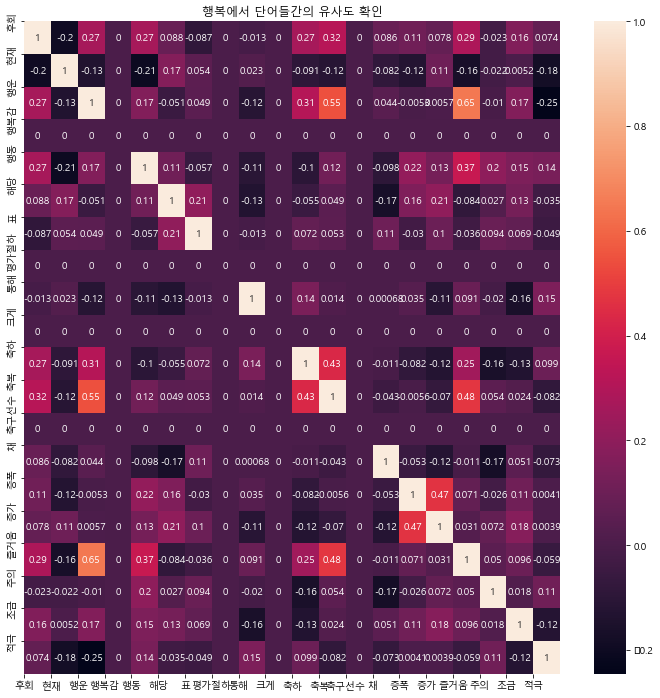

In [84]:
XYZ.topn(20)
XYZ.get_heatmap('행복',(12,12))

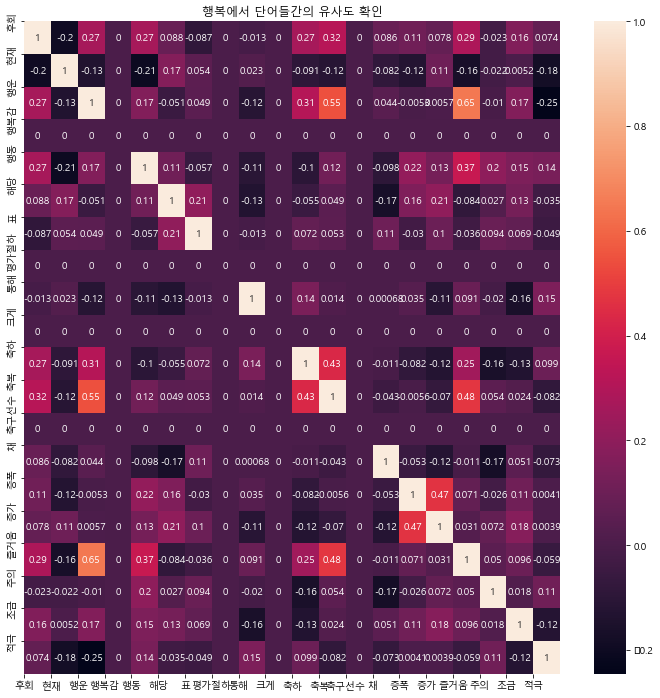

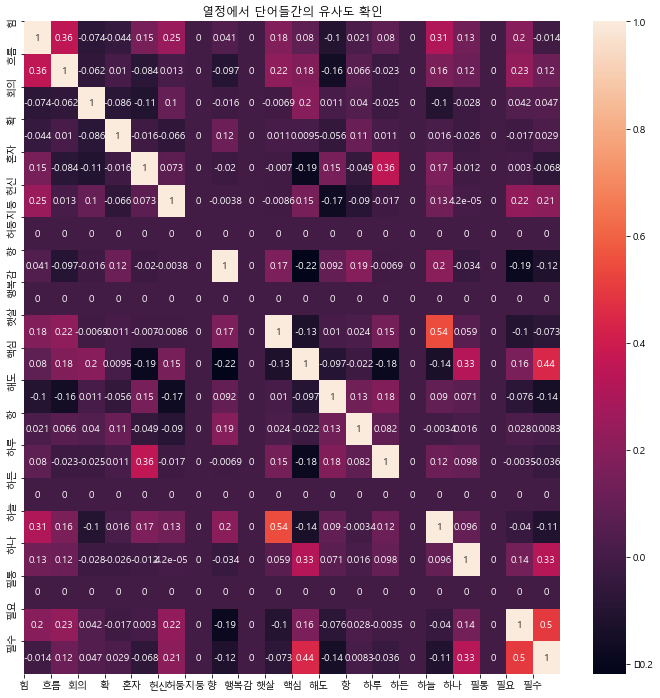

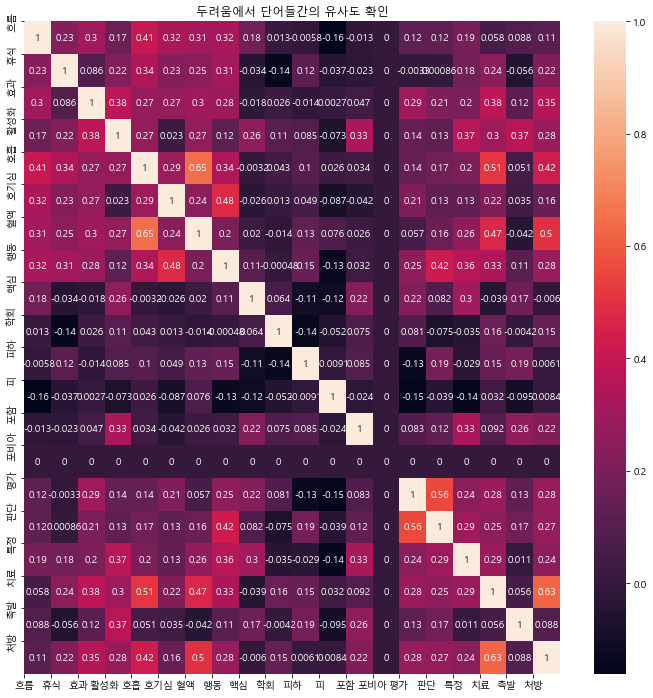

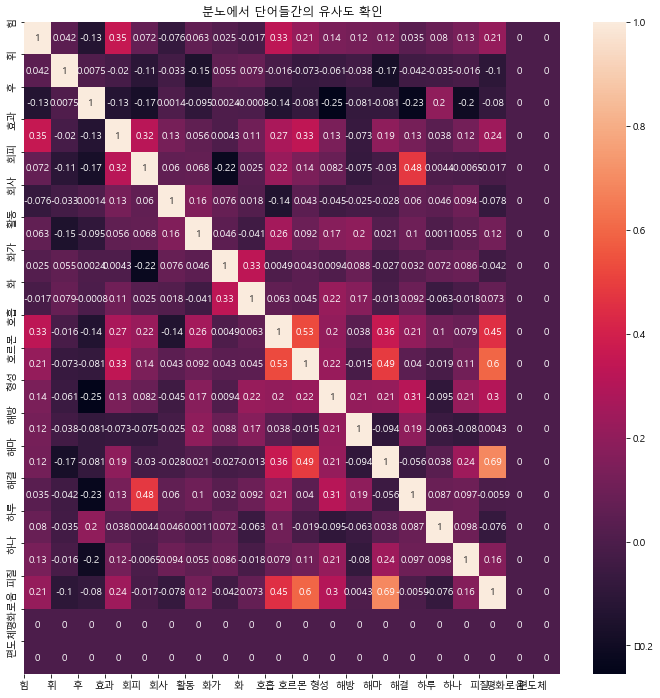

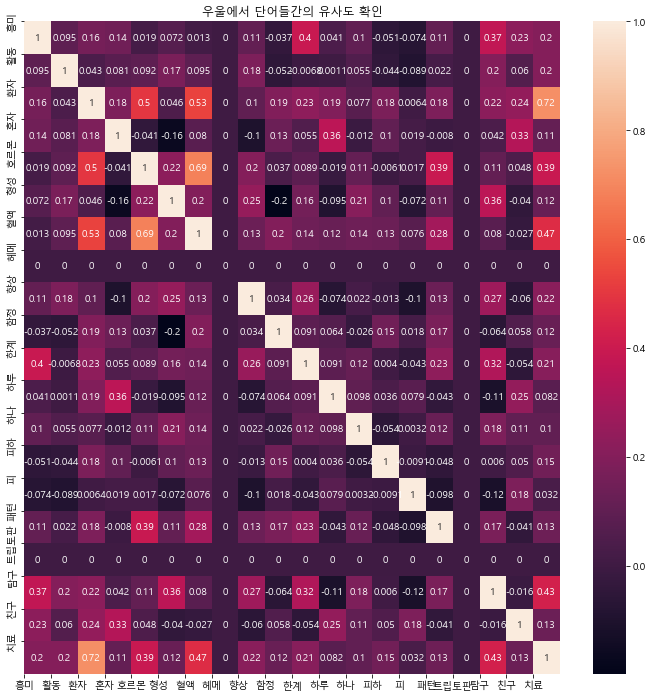

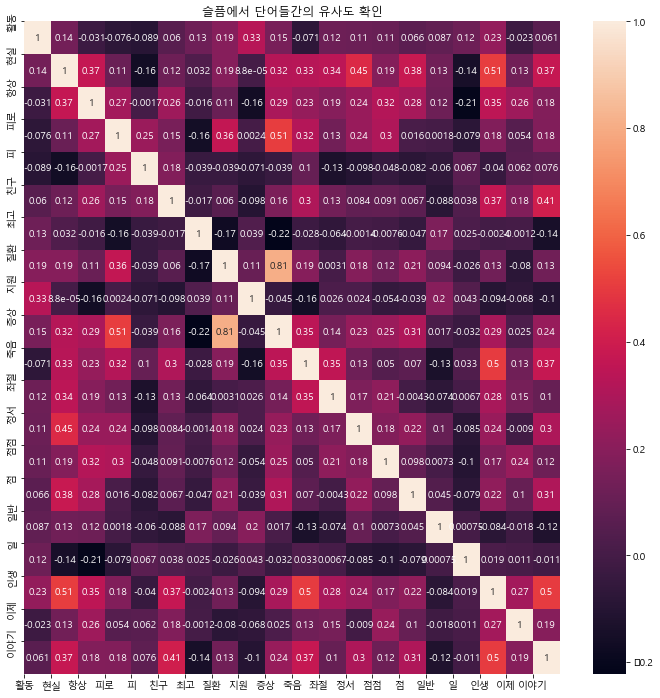

In [85]:
em_name = ['행복', '열정', '두려움', '분노', '우울', '슬픔']
XYZ.topn(20)
for em in em_name:
    XYZ.get_heatmap(em,(12,12))

In [86]:
XYZ.count_to_csv('count_result_stopwording.csv')
topn = 1000
XYZ.sim_word_to_csv(1000,f'simwords {topn} in wiki data.csv')

,행복,Similarity,열정,Similarity,두려움,Similarity,분노,Similarity,우울,Similarity,슬픔,Similarity
0,사랑,0.776711,애정,0.776711,불안감,0.776711,격노,0.776711,강렬,0.776711,기쁨,0.776711
1,기쁨,0.771050,정열,0.771050,죄책감,0.771050,격분,0.771050,무기력,0.771050,절망,0.771050
2,즐거움,0.743100,열망,0.743100,적개심,0.743100,원망,0.743100,애절,0.743100,아픔,0.743100
3,삶,0.729768,자신감,0.729768,열등감,0.729768,분개,0.729768,경쾌,0.729768,비탄,0.729768
4,젊음,0.725148,자부심,0.725148,편견,0.725148,질투,0.725148,예리,0.725148,고독,0.725148
...,...,...,...,...,...,...,...,...,...,...,...,...
995,신이,0.320282,합법성,0.320282,문란,0.320282,삼손,0.320282,청렴,0.320282,초승달,0.320282
996,축하,0.320249,동향,0.320249,주술,0.320249,야욕,0.320249,감격,0.320249,소문,0.320249
997,불공평,0.320016,각별,0.320016,자폐증,0.320016,과보,0.320016,감소,0.320016,애기,0.320016
998,충성심,0.320014,후배,0.320014,체하,0.320014,일변,0.320014,환생,0.320014,크레온,0.320014
